In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
reponses = db.anon_student_task_responses.find({'correct':False})[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.head())

                        _id behavioral_traits  bonus  correct      diff  \
0  5a00f1739100de1a390000e7                []  False    False  0.284006   
1  5a00f1739100de1a390000ea                []  False    False  0.168491   
2  5a00f1739100de1a39000108                []  False    False  0.159949   
3  5a00f1739100de1a3900010d                []  False    False  0.569281   
4  5a00f1739100de1a39000128   [hops_vs_ticks]  False    False  0.000000   

           id  incomplete           lesson  \
0  39Y1vECA2c       False  review_lesson_4   
1  faYl5HT_Sn       False  review_lesson_4   
2  jGq7IGYWTF       False  review_lesson_1   
3  gM26ScOfQr       False  review_lesson_1   
4  iFYu9imr7r       False         nline_1a   

                                       level_summary  \
0  {'subject': 'review', 'unit_name': '', 'title'...   
1  {'subject': 'review', 'unit_name': '', 'title'...   
2  {'type': 'lesson', 't_elapsed': 193872, 'descr...   
3  {'type': 'lesson', 't_elapsed': 193872, 'desc

In [8]:
df_responses.shape

(100000, 27)

In [9]:
df2 = df_responses.join(pd.DataFrame(df_responses["student"].to_dict()).T)

In [10]:
df2 = df2.join(pd.DataFrame(df2['level_summary'].to_dict()).T)

In [11]:
df2 = df2.join(pd.DataFrame(df2['problems'].to_dict()).T)

In [12]:
df3  = df2.copy()

In [13]:
## Look act columns
print (df_responses.columns)

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched'],
      dtype='object')


In [14]:
## How many data samples
print (len(df_responses), "Number of entries")

100000 Number of entries


In [15]:
## Make 'description' a feature wih important words mapped

In [16]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong'],
      dtype='object')

In [17]:
df3['percent_correct'] = df3['nright'].astype(float) / df3['ntotal']

In [18]:
df3.iloc[0]

_id                                              5a00f1739100de1a390000e7
behavioral_traits                                                      []
bonus                                                               False
correct                                                             False
diff                                                             0.284006
id                                                             39Y1vECA2c
incomplete                                                          False
lesson                                                    review_lesson_4
level_summary           {'subject': 'review', 'unit_name': '', 'title'...
problem_set             lessons/fractions/lesson10/quarters_ab/quarter...
problem_set_id                                                 BYGzN1ZApc
problem_set_subspace                                                 set2
qual_id                                        BYGzN1ZApc.set2.39Y1vECA2c
randomly_selected                     

In [19]:
for idx in range(100):
    print ('index"', idx)
    print (df3.iloc[idx]['lesson'])
    print (df3.iloc[idx]['response'])

index" 0
review_lesson_4
None
index" 1
review_lesson_4
None
index" 2
review_lesson_1
{'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/shark.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}], 'fraction_cblock_containment': {}, 'input': '6', 'numberline_associations': [[{'position': 722, 'pos_value': 1.0028985507246377, 'obj_name': 'object', 'obj_value': None}]], 'fraction_cblock_chains': [{'sum': {'denominator': 1, 'numerator': 1, '__as3_type': 'Fraction'}, 'lcm_sum': {'denominator': 6, 'numerator': 6, '__as3_type': 'Fraction'}, 'pieces': ['1/6', '1/6', '1/6', '1/6', '1/6', '1/6'], 'left': 165, 'right': 856}], 'fraction_cblock_total_count': 6, 'fraction_cblock_counts': {'1/6': 6}}
index" 3
review_lesson_1
{'whole': '', 'fraction_input_value': '1/3', 'fraction_cblock_chains': [{'sum': {'denominator': 1, 'numerator': 1, '__as3_type': 'Fraction'}, 'lcm_sum': {'denominator': 3, 'numerator': 3, '__a

In [20]:
def stringify_response(resp):
    my_val = str(resp).replace("': ","_")
    my_val = my_val.replace("_{"," ")
    my_val = my_val.replace("_[",", ")
    for c in [']','[','{','}',"'","",","]:
        my_val = my_val.replace(c,'')
    return my_val


In [21]:
stringify_response(df3.iloc[0]['response'])

'None'

In [22]:
df3['response_str'] = df3['response'].apply(stringify_response)

In [23]:
for idx in range(20):
    print (idx, df3['response_str'].iloc[idx])

0 None
1 None
2 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/objects/shark.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf fraction_cblock_containment  input_6 numberline_associations position_722 pos_value_1.0028985507246377 obj_name_object obj_value_None fraction_cblock_chains sum denominator_1 numerator_1 __as3_type_Fraction lcm_sum denominator_6 numerator_6 __as3_type_Fraction pieces 1/6 1/6 1/6 1/6 1/6 1/6 left_165 right_856 fraction_cblock_total_count_6 fraction_cblock_counts 1/6_6
3 whole_ fraction_input_value_1/3 fraction_cblock_chains sum denominator_1 numerator_1 __as3_type_Fraction lcm_sum denominator_3 numerator_3 __as3_type_Fraction pieces 1/3 1/3 1/3 left_96 right_657 fraction_cblock_containment  num_1 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_frac

In [24]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong', 'percent_correct', 'response_str'],
      dtype='object')

In [25]:
## In Response:
### convert K, V, and all K_V into words in a text doc
### Then add text
### The add description


In [26]:
def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
        

        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans
        
            
            

In [27]:
df3['response_doc'] = df3['response'].map(make_string)

In [28]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [29]:
#df3['response_doc'] = df3['response_doc'] + df3['txt'] 

In [30]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [31]:
#df3['response_doc'] = df3['response_doc'] +  df3['description']

In [32]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))

In [33]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

In [34]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects_v2/shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71   '

In [35]:
df3.iloc[100]['response']

{'input': '11',
 'numberline_associations': [[{'obj_name': 'object',
    'obj_value': None,
    'pos_value': 0.7128229702353126,
    'position': 572.5612903225807}]],
 'plain_image_groups': [{'total': 1,
   'url': 'assets/cms/wootmath_fractions/number_line/objects_v2/shark_goggles.swf'},
  {'total': 1,
   'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}]}

In [36]:
for idx in range(20):
    print (idx, df3['response_doc'].iloc[idx])

0   
1   
2   plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects/shark.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf   input_6    numberline_associations_ position_722 numberline_associations_ pos_value_1.0 numberline_associations_ obj_name_object numberline_associations_   fraction_cblock_chains_ sum_ denominator_1 sum_ numerator_1 sum_ __as3_type_Fraction fraction_cblock_chains_ lcm_sum_ denominator_6 lcm_sum_ numerator_6 lcm_sum_ __as3_type_Fraction fraction_cblock_chains_  pieces_1/6  pieces_1/6  pieces_1/6  pieces_1/6  pieces_1/6  pieces_1/6 fraction_cblock_chains_ left_165 fraction_cblock_chains_ right_856  fraction_cblock_total_count_6  fraction_cblock_counts_ 1/6_6   
3  whole_  fraction_input_value_1/3   fraction_cblock_chains_ sum_ denominator_1 sum_ numerator_1 sum_ __as3_type_Fraction fraction_cblock_chains_ lcm_sum_ denominator_3 lcm_sum_ numerat

In [37]:
df3['response_doc'] = df3['response_doc'].map( lambda x: " ".join(x.split('/')) if '/' in x else x)

In [38]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets cms wootmath_fractions number_line objects_v2 shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions number_line markers start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71   '

In [39]:
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace('[',' '))
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace(']',' '))

In [40]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets cms wootmath_fractions number_line objects_v2 shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions number_line markers start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71   '

In [41]:
docs = list(df3['response_doc'])

In [42]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [43]:
data_samples = docs

In [44]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [45]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

Extracting tf-idf features for NMF...


In [46]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


done in 6.151s.


In [47]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 7.578s.


In [48]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [49]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 7.289s.
Extracting tf features for LDA...
done in 5.627s.


In [50]:

from sklearn.cluster import KMeans, MiniBatchKMeans
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)

In [51]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(tf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
done in 0.921s



In [52]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: fraction_circle_groups_ pieces_1 fraction_circle_counts_ scale_1 y_350 fraction_circle_total_count_2 scale_0 x_250 x_750 2_1
Cluster 1: fraction_cblock_chains_ sum_ lcm_sum_ __as3_type_fraction numerator_1 pieces_1 denominator_2 fraction_cblock_counts_ denominator_1 denominator_3
Cluster 2: fraction_cblock_chains_ sum_ lcm_sum_ __as3_type_fraction numerator_1 pieces_1 denominator_1 fraction_cblock_counts_ fraction denominator_2
Cluster 3: pieces_1 10 12 lcm_sum_ sum_ fraction_cblock_chains_ fraction __as3_type_fraction numberline_associations_ 15
Cluster 4: plain_image_groups_ url_assets swf wootmath_fractions cms total_1 equal_parts radio_group_mc2_ radio_group_mc1_ whole_
Cluster 5: pieces_1 fraction_circle_groups_ chains_ lcm_sum_ sum_ __as3_type_fraction 15 fraction 10 scale_0
Cluster 6: pieces_1 fraction_cblock_chains_ lcm_sum_ sum_ __as3_type_fraction 12 numerator_1 denominator_1 fraction_cblock_counts_ bar1_
Cluster 7: fraction_cblock_chains_ lc

In [53]:
len(km.labels_)

100000

In [54]:
np.bincount(km.labels_)

array([ 1138,   614,  1273,    31,  3489,   892,   687,   622,  2074,
         773,    70,   837,   255,   769,   200,   840,     0,  2045,
        2062,    98,  1291,   915, 13022,     0,  1129,   690,     0,
        1182,   280,    35,  1074,   192,    99,     5,   312,    97,
          38,  1012,   132,    76,   127,  1134,   154,   156,  2653,
           0,   172,   277,   826,    40,   316,   599,  1022,     0,
        4735,   561,     5,   338,  2964,   366,  1037,    77,    15,
        1491,    68,    38,   611,   100,   683,   558,   892,   139,
        1578,  1652,    56,   584,  1157,   956,   934,   959,  1171,
         706,     0, 15956,  1720,  1120,     0,   315,    67,   184,
        1332,  3247,     0,    17,  1491,   503,   360,   130,  1058,   243])

In [55]:
df3['cluster_100'] = km.labels_

In [56]:
len(np.bincount(km.labels_))

100

In [57]:
df3['cluster_100'] = km.labels_


In [58]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )

In [59]:
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [60]:
df3['trait_1'].value_counts()

None                             66277
inverts_numerator_denominator     5651
how_to_model                      4082
identifying_gt_lt                 3703
starting_from_0_nline             1782
counting_hops_not_ticks           1622
recognizing_the_whole             1371
deci_incorrect_inequality         1339
deci_understanding_gt_lt          1317
inequality_symbol                 1240
partially_drawn_parts             1132
dragging_to_add                    871
modeled_incorrect_comparison       837
partitioning_number_line           804
simplifying_bars_2                 790
deci_placing_decimal_points        595
misplaced_fraction_part_nline      538
simplifying_subtraction            523
measuring_tools                    517
hops_vs_ticks                      501
comparing_frac_gt_lt               473
only_tenths_entered                418
fraction_of_set                    371
multiplying_whole_by_proper        361
deci_forgot_decimal_point          291
simplify_with_common_deno

In [61]:
df3['trait_2'].value_counts()

None                            94762
equally_sized_parts              1132
modeled_incorrect_numerator       837
wrong_number_parts                804
simplifying_mixed_numbers         798
orange_tick                       517
simplifying_answers_nline         512
dragging_to_add_3_circles         262
nline_restart_one                 192
deci_break_tenths_hundredths      175
modulo_ans                          9
Name: trait_2, dtype: int64

In [62]:
df_cluster_100 = df3.groupby('cluster_100')

In [63]:
len(df_cluster_100)

92

In [64]:
df_cluster_100.head()

,_id,behavioral_traits,bonus,correct,diff,id,incomplete,lesson,level_summary,problem_set,...,nright,ntotal,nuntouched,nwrong,percent_correct,response_str,response_doc,cluster_100,trait_1,trait_2
0,5a00f1739100de1a390000e7,[],False,False,0.284006,39Y1vECA2c,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson10/quarters_ab/quarter...,...,1,4,1,3,0.250000,None,,83,None,None
1,5a00f1739100de1a390000ea,[],False,False,0.168491,faYl5HT_Sn,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson11/thirds/media/proble...,...,0,3,4,3,0.000000,None,,83,None,None
2,5a00f1739100de1a39000108,[],False,False,0.159949,jGq7IGYWTF,False,review_lesson_1,"{'type': 'lesson', 't_elapsed': 193872, 'descr...",lessons/fractions/lesson13_1/part_b/media/prob...,...,3,6,0,3,0.500000,plain_image_groups total_1 url_assets/cms/woot...,plain_image_groups_ total_1 plain_image_grou...,18,None,None
3,5a00f1739100de1a3900010d,[],False,False,0.569281,gM26ScOfQr,False,review_lesson_1,"{'type': 'lesson', 't_elapsed': 193872, 'descr...",lessons/fractions/lesson13_1/part_a/media/prob...,...,3,6,0,3,0.500000,whole_ fraction_input_value_1/3 fraction_cbloc...,whole_ fraction_input_value_1 3 fraction_c...,18,None,None
4,5a00f1739100de1a39000128,[hops_vs_ticks],False,False,0.000000,iFYu9imr7r,False,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_a/media/prob...,...,10,14,0,4,0.714286,num_1 fraction_input_value_Fraction 1 numberli...,num_1 fraction_input_value_ Fraction 1 w...,58,hops_vs_ticks,None
5,5a00f1739100de1a39000130,"[partitioning_number_line, wrong_number_parts]",False,False,0.105381,RpNOh3tBju,True,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_b/media/prob...,...,10,14,0,4,0.714286,whole_ fraction_input_value_Fraction 1 den_inp...,whole_ fraction_input_value_ Fraction 1 de...,58,partitioning_number_line,wrong_number_parts
6,5a00f1739100de1a39000133,"[partitioning_number_line, wrong_number_parts]",False,False,0.277946,rhkFQkJo1i,False,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_b/media/prob...,...,10,14,0,4,0.714286,whole_ fraction_input_value_Fraction 1 den_inp...,whole_ fraction_input_value_ Fraction 1 de...,58,partitioning_number_line,wrong_number_parts
7,5a00f1739100de1a39000192,[],True,False,1.000000,YW-9tGkI85,False,simplify_1,{'title': 'Fractions in Simplest Form with Mod...,lessons/fractions/lesson41/bonus/media/problem...,...,4,5,0,1,0.800000,fraction_cblock_counts 1_1 1/4_3 fraction_cblo...,fraction_cblock_counts_ 1_1 fraction_cblock_c...,1,None,None
8,5a00f1739100de1a390001a2,[],True,False,0.500000,tsNFPpXlNF,False,simplify_3,{'title': 'Fractions in Simplest Form - Part 2...,lessons/fractions/lesson43/bonus/media/problem...,...,4,5,0,1,0.800000,den_3 whole_ fraction_cblock_containment Fract...,den_3 whole_ fraction_cblock_containment_ ...,15,None,None
9,5a00f1739100de1a390001a8,[],False,False,0.000000,q2ElZZuy7P,False,division_8,"{'entered': True, 't_elapsed': 115577, 'unit_n...",lessons/fractions/lesson85/part_b/media/proble...,...,3,7,0,4,0.428571,None,,83,None,None


In [65]:
df3['percent_correct'].groupby(df3['cluster_100']).describe()

,count,mean,std,min,25%,50%,75%,max
cluster_100,,,,,,,,
0,1138.0,0.524985,0.291642,0.0,0.333333,0.600000,0.777778,0.909091
1,614.0,0.572354,0.289793,0.0,0.500000,0.666667,0.800000,0.909091
2,1273.0,0.568499,0.283222,0.0,0.428571,0.666667,0.800000,0.909091
3,31.0,0.595328,0.316801,0.0,0.261905,0.750000,0.800000,0.888889
4,3489.0,0.484452,0.307515,0.0,0.142857,0.571429,0.777778,0.909091
5,892.0,0.544015,0.285994,0.0,0.333333,0.625000,0.800000,0.909091
6,687.0,0.636705,0.266889,0.0,0.545455,0.750000,0.800000,0.909091
7,622.0,0.548912,0.273312,0.0,0.400000,0.600000,0.777778,0.909091
8,2074.0,0.600620,0.261724,0.0,0.500000,0.666667,0.800000,0.909091


In [66]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)

In [67]:
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [68]:
df_trait_2

trait_2,None,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,
0,1138,0,0,0,0,0,0,0,0,0,0
1,614,0,0,0,0,0,0,0,0,0,0
2,1177,0,0,0,96,0,0,0,0,0,0
3,31,0,0,0,0,0,0,0,0,0,0
4,2381,0,0,1108,0,0,0,0,0,0,0
5,714,0,153,0,0,0,0,0,0,25,0
6,687,0,0,0,0,0,0,0,0,0,0
7,597,0,0,0,25,0,0,0,0,0,0
8,1985,89,0,0,0,0,0,0,0,0,0


In [69]:
df_trait_2.columns

Index(['None', 'deci_break_tenths_hundredths', 'dragging_to_add_3_circles',
       'equally_sized_parts', 'modeled_incorrect_numerator', 'modulo_ans',
       'nline_restart_one', 'orange_tick', 'simplifying_answers_nline',
       'simplifying_mixed_numbers', 'wrong_number_parts'],
      dtype='object', name='trait_2')

In [70]:
df_trait_1.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [71]:
[x for x in df_trait_2.columns if x not in df_trait_1.columns ]

['dragging_to_add_3_circles',
 'equally_sized_parts',
 'modeled_incorrect_numerator',
 'modulo_ans',
 'nline_restart_one',
 'orange_tick',
 'simplifying_answers_nline',
 'wrong_number_parts']

In [72]:
[x for x in df_trait_1.columns if x not in df_trait_2.columns ]

['area_model',
 'benchmark_1_2',
 'benchmark_quarters',
 'comparing_frac_gt_lt',
 'counting_hops_for_division',
 'counting_hops_not_ticks',
 'deci_add_to_model',
 'deci_building_tenths',
 'deci_compare_no_models',
 'deci_forgot_decimal_point',
 'deci_hops_instead_ticks',
 'deci_hundredths_vs_tenths',
 'deci_incorrect_inequality',
 'deci_placing_decimal_points',
 'deci_point_location_correct',
 'deci_tens_vs_tenths',
 'deci_understanding_gt_lt',
 'determine_the_frac_part',
 'dragging_to_add',
 'fraction_of_set',
 'hops_vs_ticks',
 'how_to_model',
 'identifying_gt_lt',
 'inequality_symbol',
 'inverts_numerator_denominator',
 'measuring_tools',
 'misplaced_fraction_part_nline',
 'mixed_number_quotient',
 'mixed_numbers_on_number_line',
 'modeled_incorrect_comparison',
 'modeling_fraction_division',
 'multiplication',
 'multiplying_whole_by_proper',
 'nline_as_whole',
 'numerator_off_by_one_nline',
 'only_tenths_entered',
 'partially_drawn_parts',
 'partitioning_number_line',
 'recognizing

In [73]:
#df_trait_1 = df_trait_1.drop('None', axis=1)
#df_trait_2 = df_trait_2.drop('None', axis=1)

In [74]:
df_traits = pd.merge(left=df_trait_1,right=df_trait_2, how='left' )


In [75]:
df_trait_1.index.rename('cluster_100', inplace=True)

In [76]:
df_trait_2.index.rename('cluster_100', inplace=True)

In [77]:
df_traits.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [78]:
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [79]:
print (df_traits.shape)
print (df_trait_1.shape)
print (df_trait_2.shape)


(92, 62)
(92, 51)
(92, 11)


In [80]:
df_traits.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [81]:
df_traits

,None,area_model,benchmark_1_2,benchmark_quarters,comparing_frac_gt_lt,counting_hops_for_division,counting_hops_not_ticks,deci_add_to_model,deci_break_tenths_hundredths,deci_building_tenths,...,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,,,,,,,,,,,
0,779,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,497,0,0,0,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1062,0,0,0,0,0,0,0,0,0,...,0,0,0,96,0,0,0,0,0,0
3,20,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1883,0,0,0,0,0,0,0,0,0,...,0,0,1108,0,0,0,0,0,0,0
5,384,0,0,0,0,0,0,0,0,0,...,0,153,0,0,0,0,0,0,25,0
6,663,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,465,0,0,0,0,0,0,0,0,0,...,0,0,0,25,0,0,0,0,0,0
8,1857,0,0,0,59,24,0,0,0,0,...,89,0,0,0,0,0,0,0,0,0


In [82]:
df_traits = df_traits.drop('None', axis=1)

In [83]:
df_traits

,area_model,benchmark_1_2,benchmark_quarters,comparing_frac_gt_lt,counting_hops_for_division,counting_hops_not_ticks,deci_add_to_model,deci_break_tenths_hundredths,deci_building_tenths,deci_compare_no_models,...,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,96,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1108,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,153,0,0,0,0,0,0,25,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,25,0,0,0,0,0,0
8,0,0,0,59,24,0,0,0,0,0,...,89,0,0,0,0,0,0,0,0,0


In [84]:
import seaborn as sns

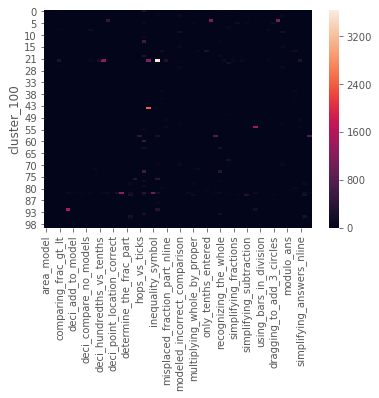

In [85]:
sns.heatmap(df_traits)

In [86]:
df_traits.to_csv('cluster_100.csv')

In [87]:
df_traits2 = pd.concat([df3['percent_correct'].groupby(df3['cluster_100']).describe(), df_traits], axis=1)

In [88]:
df_traits2.to_csv('cluster_100_plus_correct.csv')

In [89]:
df_traits_dict = df_traits.to_dict(orient='dict')

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/pandas/core/frame.py:881: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [90]:
df_traits_dict

{'area_model': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  24: 0,
  25: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  83: 16,
  84: 0,
  85: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0},
 'benchmark_1_2': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  17: 0,
  18: 

In [91]:
df_traits_dict2 = {}
cluster_with_no_trait = list(np.arange(100))
cluster_with_lt_10_trait = list(np.arange(100))

In [92]:
for trait in df_traits_dict:
    #print (idx, trait)
    df_traits_dict2[trait] = {}
    for cluster in df_traits_dict[trait]:
        #print (trait, cluster, df_traits_dict[trait][cluster])
        if  df_traits_dict[trait][cluster] > 0:
            df_traits_dict2[trait][cluster] = df_traits_dict[trait][cluster]
            if cluster in cluster_with_no_trait:
                cluster_with_no_trait.remove(cluster)
            if  df_traits_dict[trait][cluster] > 9:
                if cluster in cluster_with_lt_10_trait:
                    cluster_with_lt_10_trait.remove(cluster)

In [93]:
print (df_traits_dict2)

{'area_model': {83: 16}, 'benchmark_1_2': {72: 4}, 'benchmark_quarters': {72: 25}, 'comparing_frac_gt_lt': {1: 48, 3: 1, 6: 1, 8: 59, 10: 1, 14: 1, 19: 5, 21: 1, 22: 286, 25: 43, 27: 3, 28: 1, 30: 3, 52: 3, 71: 2, 75: 1, 83: 11, 85: 2, 90: 1}, 'counting_hops_for_division': {8: 24, 25: 3, 39: 1, 83: 9}, 'counting_hops_not_ticks': {83: 113, 91: 1509}, 'deci_add_to_model': {83: 60}, 'deci_break_tenths_hundredths': {8: 89, 22: 59, 25: 2, 83: 25}, 'deci_building_tenths': {83: 51}, 'deci_compare_no_models': {22: 35, 83: 7}, 'deci_forgot_decimal_point': {8: 134, 22: 82, 25: 6, 83: 69}, 'deci_hops_instead_ticks': {7: 1, 12: 1, 18: 28, 59: 3, 69: 4, 70: 1, 72: 91, 81: 2, 83: 5}, 'deci_hundredths_vs_tenths': {22: 220, 83: 1}, 'deci_incorrect_inequality': {22: 1267, 83: 72}, 'deci_placing_decimal_points': {4: 498, 83: 97}, 'deci_point_location_correct': {2: 1, 7: 2, 12: 7, 15: 1, 18: 52, 52: 1, 59: 1, 69: 1, 72: 41, 81: 19, 83: 6}, 'deci_tens_vs_tenths': {83: 245}, 'deci_understanding_gt_lt': {83

In [94]:
cluster_with_no_trait, 

([16, 23, 26, 29, 32, 36, 43, 45, 53, 56, 67, 82, 86, 89, 92, 93],)

In [95]:
len(cluster_with_no_trait)

16

In [96]:
len(cluster_with_lt_10_trait)

34

In [97]:
x = list(df_traits.index)

In [98]:
df_traits.shape

(92, 60)

In [99]:
y = df_traits.sum(axis=1)

In [100]:
y

cluster_100
0      359
1      117
2      307
3       11
4     2714
5      686
6       24
7      182
8      306
9      403
10      15
11     153
12      37
13     653
14       3
15     239
17      36
18     802
19      28
20     406
21      88
22    7817
24     367
25     118
27     306
28      11
29       0
30      81
31       9
32       0
      ... 
67       0
68     299
69     146
70     315
71      32
72     321
73    1034
74       8
75      84
76     780
77     221
78     306
79     142
80     214
81     232
83    5154
84    1239
85     101
87      23
88      57
89       0
90      38
91    2044
93       0
94     459
95     576
96     132
97       9
98      12
99      53
Length: 92, dtype: int64

<Container object of 92 artists>

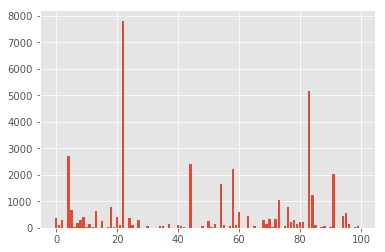

In [101]:

plt.bar( x, y)


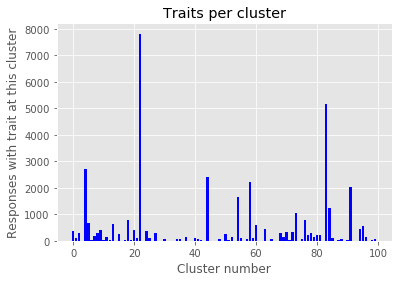

In [102]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster')
ax.set_title('Traits per cluster')



In [103]:
counts_per_cluster = np.bincount(km.labels_)

In [104]:
print (counts_per_cluster)

[ 1138   614  1273    31  3489   892   687   622  2074   773    70   837
   255   769   200   840     0  2045  2062    98  1291   915 13022     0
  1129   690     0  1182   280    35  1074   192    99     5   312    97
    38  1012   132    76   127  1134   154   156  2653     0   172   277
   826    40   316   599  1022     0  4735   561     5   338  2964   366
  1037    77    15  1491    68    38   611   100   683   558   892   139
  1578  1652    56   584  1157   956   934   959  1171   706     0 15956
  1720  1120     0   315    67   184  1332  3247     0    17  1491   503
   360   130  1058   243]


In [105]:
counts_per_cluster = list(counts_per_cluster)

In [106]:
counts_per_cluster.remove(0)

In [107]:
counts_per_cluster = np.array(counts_per_cluster)

In [108]:
y1 = y / counts_per_cluster

ValueError: operands could not be broadcast together with shapes (92,) (99,) 

In [ ]:
y

In [ ]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y1, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster/ total response at cluster')
ax.set_title('Traits per cluster')